# Train voice embedding

Perform sanity check using low amount of data

- Prepare dataset
- Train model

Full scale training

- What can fit memory?

In [2]:
import os
import tarfile
from IPython.display import Audio

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt

audio_tarfile = 'data/en.tar'
en_total = 1584330

sr = 48000
audios_tar = tarfile.open(name=audio_tarfile, mode='r')

# for the English tarfile, we already know the max
tar_file_list = [x for x in tqdm(audios_tar, total=en_total)]

  0%|          | 0/1584330 [00:00<?, ?it/s]

In [3]:
data_files = {
    'train.tsv': None,
    'dev.tsv': None,
    'test.tsv': None,
    # 'validated.tsv': None
}
n_files = len(data_files.keys())
cur_files = 0

for x in tar_file_list:
    for k in data_files:
        if x.name.endswith(k):
            with audios_tar.extractfile(x) as f:
                df = pd.read_csv(f, sep='\t')
                data_files[k] = df
            cur_files += 1
    if cur_files == n_files:
        break

In [22]:
# learn to map files to id's
path_to_client_dict = dict(zip(data_files['train.tsv'].path, data_files['train.tsv'].client_id))

data_files['train.tsv'].head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731809.mp3,Hannu wrote of his expedition in stone.,3,0,NaN,NaN,NaN,en,NaN
1,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731810.mp3,Little India differs from many other neighbour...,3,1,NaN,NaN,NaN,en,NaN
2,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731811.mp3,Users had the ability to vote on the songs the...,2,0,NaN,NaN,NaN,en,NaN
3,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731812.mp3,"His major sponsor is Algario Communications, a...",2,1,NaN,NaN,NaN,en,NaN
4,cb118ddafaf4a59525bb7f8350549beb5f3d7720c8d83a...,common_voice_en_19968207.mp3,The mansion also has a marriage office.,2,0,NaN,NaN,NaN,en,NaN


In [25]:
audio_content = {}
for x in tqdm(tar_file_list):
    name_split = x.name.split('/')
    cur_id = path_to_client_dict.get(name_split[-1], False)
    if cur_id:
        audio_data = audios_tar.extractfile(x).read()
        cur_id_dict = audio_content.get(cur_id, [])
        cur_id_dict.append(audio_data)
        audio_content[cur_id] = cur_id_dict

  0%|          | 0/1584330 [00:00<?, ?it/s]

## Sanity check

Check if audios from the same person sound like that

In [46]:
temp_list = [x for x in audio_content if len(audio_content[x]) > 2]
cur_idx = np.random.randint(len(temp_list))
audio_samples = audio_content[temp_list[cur_idx]]
len(audio_samples)

3

In [47]:
decoded_mp3 = tfio.audio.decode_mp3(audio_samples[0])
Audio(decoded_mp3.numpy()[:, 0], rate=sr)

In [48]:
decoded_mp3 = tfio.audio.decode_mp3(audio_samples[1])
Audio(decoded_mp3.numpy()[:, 0], rate=sr)

# Model training

In [55]:
class PersonIdAudio:
    def __init__(self, audio_content, sr=48000):
        """ Constructor

        Arguments:

        audio_content: dictionary containing
            person_id as keys and a
            list of mp3-encoded samples

        sr: sampling rate
        """
        person_ids = audio_content.keys()
        labels = range(len(person_ids))
        self.id_to_label = dict(zip(person_ids, labels))

    def gen_audios(self):
        """ Generate audios and id's
        Leave the shuffling part to tf dataset
        """
        for person_id in audio_content:
            person_label = self.id_to_label[person_id]
            for item in audio_content[person_id]:
                yield audio_content[person_id], person_label

In [61]:
# at this point we could write a tfrecords
# file if we like using TFRecordWriter
# if everything fits in memory so we don't really need to

audio_signature=(
    tf.TensorSpec(shape=(None), dtype=tf.string),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

audio_dataset = tf.data.Dataset.from_generator(
     pia.gen_audios,
     output_signature=audio_signature
)

In [64]:
samples = [x for x in audio_dataset.take(10)]

In [66]:
decoded_mp3 = tfio.audio.decode_mp3(samples[0][0])
Audio(decoded_mp3.numpy()[:, 0], rate=sr)

## Model definition

In [68]:
from tensorflow.keras import Model
from tensorflow.keras import layers as L

def AttRNNSpeechModel(nCategories, samplingrate=16000,
                      inputLength=16000, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength

    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False

    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

In [203]:
# good example here
# https://www.tensorflow.org/addons/tutorials/losses_triplet
def normalized_mel_spectrogram(x, sr=48000):
    spec_stride = 128
    spec_len = 1024

    spectrogram = tfio.audio.spectrogram(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )

    num_spectrogram_bins = spec_len // 2 + 1  # spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 10000.0, 85
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    avg = tf.math.reduce_mean(log_mel_spectrograms)
    std = tf.math.reduce_std(log_mel_spectrograms)

    return (log_mel_spectrograms - avg) / std


def SpeechEmbeddingModel(inputLength=None, rnn_func=L.LSTM, rnn_units=64):
    # input is the first channel of the decoded mp3, ie, 
    # tfio.audio.decode_mp3(data)[:, 0]

    inp = L.Input((inputLength,), name='input')
    
    mel_spec = L.Lambda(lambda z: normalized_mel_spectrogram(z), name='normalized_spectrogram')(inp)

    # normalize the spectrogram
    # mel_spec = L.BatchNormalization()(mel_spec)
    # mel_spec = L.LayerNormalization()(mel_spec)

    x = L.Bidirectional(
        rnn_func(rnn_units, return_sequences=True)
    )(mel_spec)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(
        rnn_func(rnn_units, return_sequences=False)
    )(x)  # [b_s, seq_len, vec_dim]

    x = L.Dense(rnn_units, activation=None)(x)  # No activation on final dense layer
    # L2 normalize embeddings
    # note: L2 returns normalized, norm
    x = L.Lambda(lambda z: tf.math.l2_normalize(z, axis=1), name='output')(x)
    
    output = x

    model = Model(inputs=[inp], outputs=[output])
    return model

In [204]:
m = AttRNNSpeechModel()
m.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
normalized_spectrogram (Lamb (None, None, 85)          0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, None, 128)         76800     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Lambda)              (None, 64)                0         
Total params: 183,872
Trainable params: 183,872
Non-trainable params: 0
____________________________________________________

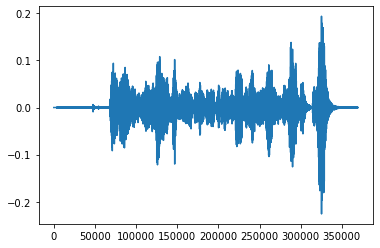

In [205]:
plt.plot(decoded_mp3)

In [ ]:
mel_spec = m.predict(tf.expand_dims(decoded_mp3[:, 0], axis=0))
mel_spec = tf.transpose(mel_spec[0])
plt.pcolormesh(mel_spec.numpy())

In [181]:
tf.math.reduce_mean(mel_spec), tf.math.reduce_max(mel_spec), tf.math.reduce_min(mel_spec)

(<tf.Tensor: shape=(), dtype=float32, numpy=-4.0513633e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.999099>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-6.1079206>)

(array([ 1177.,   265.,   486.,   606.,  3419., 54556., 92411., 63263.,
        26704.,  2678.]),
 array([-6.1079206, -5.197219 , -4.2865167, -3.3758147, -2.4651127,
        -1.5544108, -0.6437088,  0.2669931,  1.177695 ,  2.088397 ,
         2.999099 ], dtype=float32),
 <BarContainer object of 10 artists>)

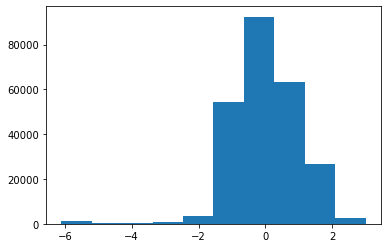

In [182]:
plt.hist(mel_spec.numpy().flatten())

### Debug code

In [6]:
# figure out the mp3 folder inside tar

for x in audios_tar:
    if x.name.endswith('.mp3'):
        mp3_folder = x.name.split('/')
        mp3_folder = '/'.join(mp3_folder[:-1])
        break
print(f'Detected mp3 folder: {mp3_folder}')

Detected mp3 folder: cv-corpus-6.1-2020-12-11/en/clips


In [67]:
# build a dictionary with key -> person id, value -> list of audios from that person

audio_per_person = {}
audio_list = data_files['train.tsv'][['client_id', 'path']].values[0:10]

for (person_id, audio_file) in tqdm(audio_list):
    audio_data = audios_tar.extractfile(mp3_folder + '/' + audio_file).read()
    person_audio_list = audio_per_person.get(person_id, [])
    person_audio_list.append(audio_data)
    audio_per_person[person_id] = person_audio_list

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# check a few audios

In [4]:
data_files['train.tsv'].head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731809.mp3,Hannu wrote of his expedition in stone.,3,0,NaN,NaN,NaN,en,NaN
1,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731810.mp3,Little India differs from many other neighbour...,3,1,NaN,NaN,NaN,en,NaN
2,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731811.mp3,Users had the ability to vote on the songs the...,2,0,NaN,NaN,NaN,en,NaN
3,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731812.mp3,"His major sponsor is Algario Communications, a...",2,1,NaN,NaN,NaN,en,NaN
4,cb118ddafaf4a59525bb7f8350549beb5f3d7720c8d83a...,common_voice_en_19968207.mp3,The mansion also has a marriage office.,2,0,NaN,NaN,NaN,en,NaN
